<a href="https://colab.research.google.com/github/mazharsaif/Attentive-AI-Dockship.io/blob/main/Dockship_Submission_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use Kaggle api to access dataset uploaded there

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
!pip install -q kaggle
! mkdir ~/.kaggle/
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mazharjamdar/custom-oversampled
! unzip '/content/custom-oversampled.zip'

print('Extracted Files')

404 - Not Found
unzip:  cannot find or open /content/custom-oversampled.zip, /content/custom-oversampled.zip.zip or /content/custom-oversampled.zip.ZIP.
Extracted Files


Import necessary libraries

In [ ]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow_addons.metrics import F1Score

from sklearn.metrics import classification_report

# Setting some parameters
%matplotlib inline
plt.rcParams['font.size']=12

Link to data exploration notebook, where I see dimension distribution, previews of images, create train/validation splits and sort files into folders by labels. Not comprehensive  
https://github.com/mazharsaif/Attentive-AI-Dockship.io/blob/main/90%20Score%20Pre%20model%20exploration.ipynb

Available data was imbalanced in categories, duplicated files in categories with fewer images to have about 2000 images in each category


In [ ]:
df = pd.read_csv('/content/Custom - Oversampled/train_df.csv', names=['image_name', 'class'],header=0)
sub = pd.read_csv('/content/Custom - Oversampled/test_challenge.csv',names=['image_name', 'class'],header=0) #Changing column names from 0,1 for convenient handling

df.head()

,image_name,class
0,0.jpg,Adhered
1,1.jpg,Adhered
2,2.jpg,Concrete
3,3.jpg,Concrete
4,4.jpg,Plastic & fabric


Use custom preprocessing function for images, default keras resizing distorts images very badly

In [ ]:
def preprocess_custom(np_img, img_height=224, img_width= 224):
    input_arr = tf.keras.preprocessing.image.img_to_array(np_img)

    input_arr = tf.keras.preprocessing.image.smart_resize(input_arr.copy(), size=(224, 224)) # np array
    input_arr = np.array(input_arr, dtype=int)
    input_arr = tf.keras.applications.mobilenet.preprocess_input(input_arr.copy())
    input_arr = tf.image.adjust_saturation(input_arr.copy(), 1.5).numpy()
    input_arr = tf.image.adjust_contrast(input_arr.copy(), 1.3)
    
    return input_arr.numpy()


def plot_total_loss():
    cumulative_history = {key:[] for key in history_1.history.keys()}

    for history_dict in history_list:
        for key in history_dict:
            cumulative_history[key] = cumulative_history[key]+ history_dict[key]
                
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(cumulative_history['accuracy'])
    plt.plot(cumulative_history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.subplot(1,2,2)
    # summarize history for loss
    plt.plot(cumulative_history['loss'])
    plt.plot(cumulative_history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.tight_layout()
    plt.show()


def plot_loss(history_1):
    ## summarize history for accuracy
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(history_1.history['accuracy'])
    plt.plot(history_1.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.subplot(1,2,2)
    # summarize history for loss
    plt.plot(history_1.history['loss'])
    plt.plot(history_1.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.tight_layout()
    plt.show()

def cb(Round_name):
    """ Call back to store model checkpoints separtely by"""
    checkpoint_path = '.weights.{epoch:02d}-{val_loss:.3f}.hdf5'
    
    checkpoint_path = Round_name + checkpoint_path
    
    call_back = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                        monitor='val_loss',
                                        verbose=0,
                                        save_best_only=False,
                                        save_weights_only=False,
                                        mode='auto',
                                        save_freq='epoch',
                                        options=None)
    return call_back

In [ ]:
data_dir = '/content/Custom - Oversampled/training_gen'
valid_dir = '/content/Custom - Oversampled/validation_gen'

img_height, img_width= 224, 224
batch_size = 32


train_datagen = ImageDataGenerator(width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   brightness_range=None,
                                   channel_shift_range=50,
                                   rotation_range=5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   preprocessing_function=lambda x: preprocess_custom(x, img_height=img_height, img_width= img_width))

valid_datagen = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=None,
                                   rotation_range=5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   preprocessing_function=lambda x: preprocess_custom(x, img_height=img_height, img_width= img_width))

train_datagen_1 = train_datagen.flow_from_directory(data_dir,
                                                   target_size=(img_height, img_width),)

valid_datagen_1 = train_datagen.flow_from_directory(valid_dir,
                                                   target_size=(img_height, img_width))

Found 11710 images belonging to 6 classes.
Found 900 images belonging to 6 classes.


In [ ]:
history_list = []

In [ ]:
mobilenet = MobileNet(input_shape=None,
                      alpha=1.0,
                      depth_multiplier=1,
                      dropout=0.005,
                      include_top=True,
                      weights="imagenet",
                      input_tensor=None,
                      pooling=None,
                      classes=1000,
                      classifier_activation="softmax")


flattened_2 = tf.keras.layers.Flatten()(mobilenet.output)

#Fully connected layer 1
fc1 = tf.keras.layers.Dense(128, activation='relu', name="AddedDense1")(flattened_2)

#Fully connected layer, output layer
fc2 = tf.keras.layers.Dense(6, activation='softmax', name="AddedDense2")(fc1)

model = tf.keras.models.Model(inputs=mobilenet.input, outputs=fc2)

Epoch 1/5
360/360 [==============================] - 371s 1s/step - loss: 1.6865 - accuracy: 0.3318 - f1_score: 0.3074 - val_loss: 1.4010 - val_accuracy: 0.4667 - val_f1_score: 0.4538
Epoch 2/5
360/360 [==============================] - 364s 1s/step - loss: 1.3641 - accuracy: 0.4750 - f1_score: 0.4657 - val_loss: 1.3050 - val_accuracy: 0.5122 - val_f1_score: 0.5051
Epoch 3/5
360/360 [==============================] - 362s 1s/step - loss: 1.2794 - accuracy: 0.5095 - f1_score: 0.5039 - val_loss: 1.2142 - val_accuracy: 0.5511 - val_f1_score: 0.5444
Epoch 4/5
360/360 [==============================] - 360s 1s/step - loss: 1.2509 - accuracy: 0.5215 - f1_score: 0.5163 - val_loss: 1.2163 - val_accuracy: 0.5289 - val_f1_score: 0.5245
Epoch 5/5
360/360 [==============================] - 368s 1s/step - loss: 1.2312 - accuracy: 0.5295 - f1_score: 0.5230 - val_loss: 1.1610 - val_accuracy: 0.5622 - val_f1_score: 0.5532


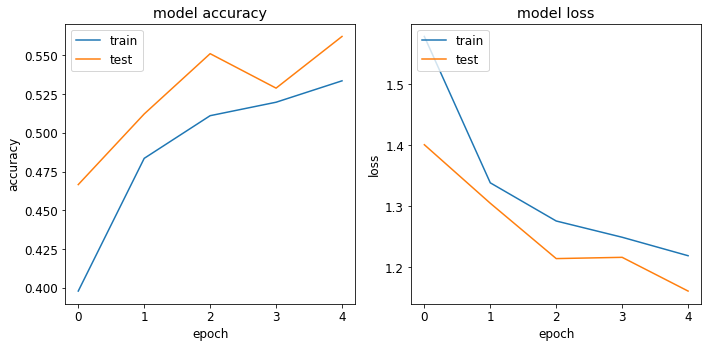

In [ ]:
# Round A

# Freeze pretrained layers for first round of training
for i in model.layers[:-2]:
    i.trainable=False
    
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(num_classes=6)])

history_1 = model.fit(train_datagen_1,
                      validation_data=valid_datagen_1,
                      steps_per_epoch=360, #total images/batchsize
                      epochs=5,
                      callbacks=[cb('A')])


history_list.append(history_1.history)

plot_loss(history_1)

Epoch 1/5
380/380 [==============================] - 386s 993ms/step - loss: 1.6708 - accuracy: 0.3891 - f1_score: 0.3716 - val_loss: 1.3632 - val_accuracy: 0.4822 - val_f1_score: 0.4768
Epoch 2/5
380/380 [==============================] - 373s 983ms/step - loss: 1.3338 - accuracy: 0.4848 - f1_score: 0.4809 - val_loss: 1.2792 - val_accuracy: 0.5089 - val_f1_score: 0.5043
Epoch 3/5
380/380 [==============================] - 372s 977ms/step - loss: 1.2458 - accuracy: 0.5234 - f1_score: 0.5197 - val_loss: 1.2168 - val_accuracy: 0.5511 - val_f1_score: 0.5541
Epoch 4/5
380/380 [==============================] - 373s 981ms/step - loss: 1.1986 - accuracy: 0.5391 - f1_score: 0.5361 - val_loss: 1.2066 - val_accuracy: 0.5433 - val_f1_score: 0.5416
Epoch 5/5
380/380 [==============================] - 373s 983ms/step - loss: 1.1740 - accuracy: 0.5541 - f1_score: 0.5525 - val_loss: 1.1699 - val_accuracy: 0.5856 - val_f1_score: 0.5814


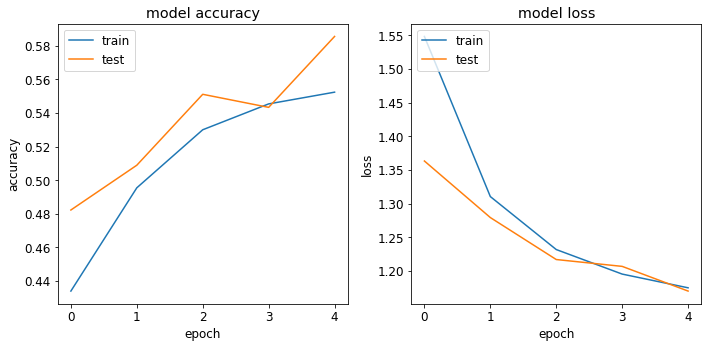

In [ ]:
# # Round A

# # Freeze pretrained layers for first round of training
# for i in model.layers[:-2]:
#     i.trainable=False
    
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy', F1Score(num_classes=6)])

# history_1 = model.fit(train_datagen_1,
#                       validation_data=valid_datagen_1,
#                       steps_per_epoch=380, #total images/batchsize
#                       epochs=5,
#                       callbacks=[cb('A'), tensorboard_callback])


# history_list.append(history_1.history)

# plot_loss(history_1)

Epoch 1/6
360/360 [==============================] - 371s 1s/step - loss: 1.2494 - accuracy: 0.5248 - f1_score: 0.5046 - val_loss: 0.9250 - val_accuracy: 0.6744 - val_f1_score: 0.6674
Epoch 2/6
360/360 [==============================] - 368s 1s/step - loss: 0.8758 - accuracy: 0.6870 - f1_score: 0.6820 - val_loss: 0.8457 - val_accuracy: 0.7100 - val_f1_score: 0.7061
Epoch 3/6
360/360 [==============================] - 367s 1s/step - loss: 0.7131 - accuracy: 0.7525 - f1_score: 0.7484 - val_loss: 0.6994 - val_accuracy: 0.7644 - val_f1_score: 0.7665
Epoch 4/6
360/360 [==============================] - 365s 1s/step - loss: 0.6742 - accuracy: 0.7591 - f1_score: 0.7629 - val_loss: 0.6191 - val_accuracy: 0.7856 - val_f1_score: 0.7862
Epoch 5/6
360/360 [==============================] - 366s 1s/step - loss: 0.5953 - accuracy: 0.7810 - f1_score: 0.7800 - val_loss: 0.5983 - val_accuracy: 0.8033 - val_f1_score: 0.8053
Epoch 6/6
360/360 [==============================] - 366s 1s/step - loss: 0.5733

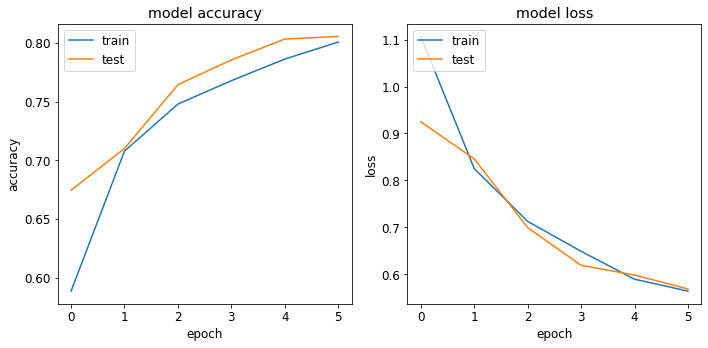

In [ ]:
# Unfreeze few more last layers
for i in model.layers[-30:]:
    i.trainable=True

opt_2 =tf.keras.optimizers.Adam(learning_rate=0.00005,
                                beta_1=0.09,
                                beta_2=0.999,
                                epsilon=1e-07,
                                amsgrad=False,
                                name='Adam2')


model.compile(optimizer=opt_2,
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(num_classes=6)])


history_2 = model.fit(train_datagen_1,
                      validation_data=valid_datagen_1,
                      steps_per_epoch=360,
                      epochs=6,
                      callbacks=[cb('B')])

history_list.append(history_2.history)

plot_loss(history_2)

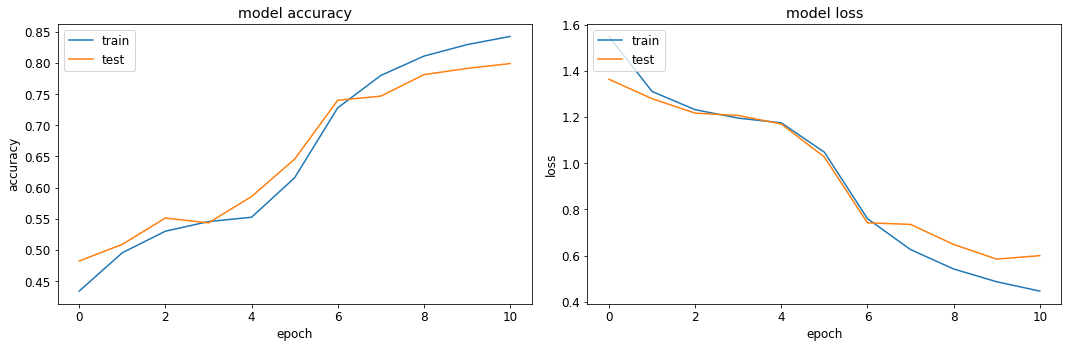

In [ ]:
plot_total_loss() #Current loss, accuracy plot so far

In [ ]:
# Unfreeze more layers
for i in model.layers[-50:]:
    i.trainable=True

opt_3 =tf.keras.optimizers.Adam(learning_rate=0.00005,
                                beta_1=0.09,
                                beta_2=0.999,
                                epsilon=1e-07,
                                amsgrad=False,
                                name='Adam3')


model.compile(optimizer=opt_3,
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(num_classes=6)])


history_3 = model.fit(train_datagen_1,
                      validation_data=valid_datagen_1,
                      steps_per_epoch=380,
                      epochs=3,
                      callbacks=[cb('C')])

history_list.append(history_3.history)

plot_loss(history_3)

Epoch 1/3
 54/380 [===>..........................] - ETA: 5:13 - loss: 0.6493 - accuracy: 0.7732 - f1_score: 0.7701

KeyboardInterrupt: ignored

Epoch 1/3
380/380 [==============================] - 420s 1s/step - loss: 0.4216 - accuracy: 0.8500 - f1_score: 0.8511 - val_loss: 0.5323 - val_accuracy: 0.8200 - val_f1_score: 0.8241
Epoch 2/3
380/380 [==============================] - 423s 1s/step - loss: 0.3579 - accuracy: 0.8786 - f1_score: 0.8790 - val_loss: 0.5092 - val_accuracy: 0.8389 - val_f1_score: 0.8417
Epoch 3/3
380/380 [==============================] - 423s 1s/step - loss: 0.3162 - accuracy: 0.8881 - f1_score: 0.8886 - val_loss: 0.4608 - val_accuracy: 0.8422 - val_f1_score: 0.8438


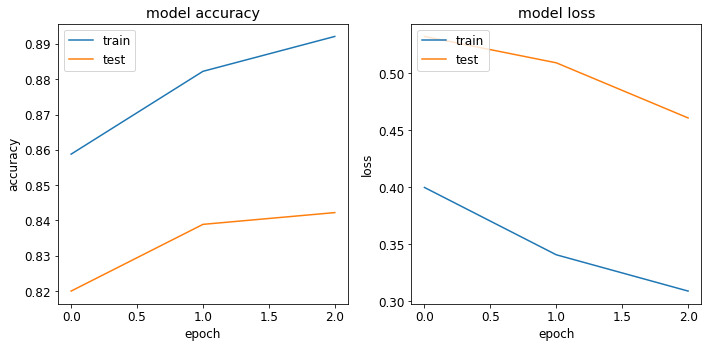

In [ ]:
# Unfreeze more layers
for i in model.layers[-75:]:
    i.trainable=True

opt_4 =tf.keras.optimizers.Adam(learning_rate=0.00005,
                                beta_1=0.09,
                                beta_2=0.999,
                                epsilon=1e-07,
                                amsgrad=False,
                                name='Adam4')


model.compile(optimizer=opt_4,
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(num_classes=6)])


history_4 = model.fit(train_datagen_1,
                      validation_data=valid_datagen_1,
                      steps_per_epoch=380,
                      epochs=3, # turn to 5 
                      callbacks=[cb('D'), tensorboard_callback]])#, reduce_lr, early_stop

history_list.append(history_4.history)

plot_loss(history_4)

Epoch 1/5
380/380 [==============================] - 456s 1s/step - loss: 0.3658 - accuracy: 0.8742 - f1_score: 0.8756 - val_loss: 0.5090 - val_accuracy: 0.8278 - val_f1_score: 0.8296
Epoch 2/5
380/380 [==============================] - 449s 1s/step - loss: 0.3051 - accuracy: 0.8928 - f1_score: 0.8930 - val_loss: 0.4705 - val_accuracy: 0.8433 - val_f1_score: 0.8449
Epoch 3/5
380/380 [==============================] - 453s 1s/step - loss: 0.2606 - accuracy: 0.9109 - f1_score: 0.9119 - val_loss: 0.4573 - val_accuracy: 0.8533 - val_f1_score: 0.8553
Epoch 4/5
380/380 [==============================] - 448s 1s/step - loss: 0.2523 - accuracy: 0.9144 - f1_score: 0.9150 - val_loss: 0.4652 - val_accuracy: 0.8511 - val_f1_score: 0.8526
Epoch 5/5
380/380 [==============================] - 450s 1s/step - loss: 0.2401 - accuracy: 0.9189 - f1_score: 0.9193 - val_loss: 0.4150 - val_accuracy: 0.8600 - val_f1_score: 0.8615


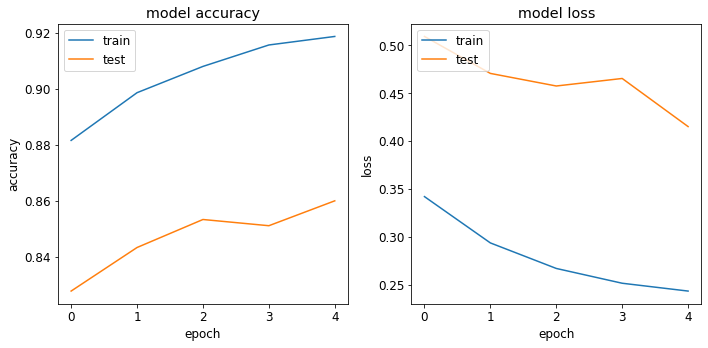

In [ ]:
# Unfreeze all layers
for i in model.layers[:]:
    i.trainable=True

opt_5 =tf.keras.optimizers.Adam(learning_rate=0.00002,
                                beta_1=0.09,
                                beta_2=0.999,
                                epsilon=1e-07,
                                amsgrad=False,
                                name='Adam5')


model.compile(optimizer=opt_5,
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(num_classes=6)])


history_5 = model.fit(train_datagen_1,
                      validation_data=valid_datagen_1,
                      steps_per_epoch=380,
                      epochs=10,
                      callbacks=[cb('E'), tensorboard_callback]])

history_list.append(history_5.history)

plot_loss(history_5)

Epoch 1/5
380/380 [==============================] - 453s 1s/step - loss: 0.2306 - accuracy: 0.9222 - f1_score: 0.9218 - val_loss: 0.4223 - val_accuracy: 0.8600 - val_f1_score: 0.8615
Epoch 2/5
380/380 [==============================] - 451s 1s/step - loss: 0.2257 - accuracy: 0.9242 - f1_score: 0.9243 - val_loss: 0.4480 - val_accuracy: 0.8589 - val_f1_score: 0.8609
Epoch 3/5
380/380 [==============================] - 449s 1s/step - loss: 0.2008 - accuracy: 0.9345 - f1_score: 0.9351 - val_loss: 0.4102 - val_accuracy: 0.8689 - val_f1_score: 0.8719
Epoch 4/5
380/380 [==============================] - 453s 1s/step - loss: 0.1898 - accuracy: 0.9374 - f1_score: 0.9378 - val_loss: 0.4567 - val_accuracy: 0.8567 - val_f1_score: 0.8589
Epoch 5/5
380/380 [==============================] - 451s 1s/step - loss: 0.1995 - accuracy: 0.9346 - f1_score: 0.9352 - val_loss: 0.4309 - val_accuracy: 0.8756 - val_f1_score: 0.8783


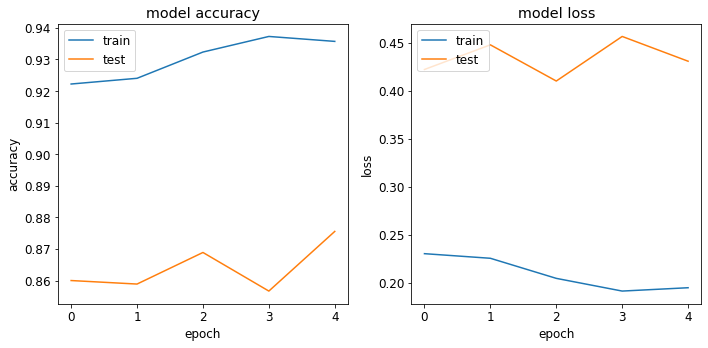

In [ ]:
# Continue Training
history_6 = model.fit(train_datagen_1,
                      validation_data=valid_datagen_1,
                      steps_per_epoch=380,
                      epochs=5,
                      callbacks=[cb('F'), tensorboard_callback]])

history_list.append(history_6.history)

plot_loss(history_6)

Epoch 1/7
380/380 [==============================] - 453s 1s/step - loss: 0.1885 - accuracy: 0.9355 - f1_score: 0.9366 - val_loss: 0.4583 - val_accuracy: 0.8611 - val_f1_score: 0.8629
Epoch 2/7
380/380 [==============================] - 448s 1s/step - loss: 0.1798 - accuracy: 0.9423 - f1_score: 0.9426 - val_loss: 0.5247 - val_accuracy: 0.8556 - val_f1_score: 0.8568
Epoch 3/7
380/380 [==============================] - 450s 1s/step - loss: 0.1942 - accuracy: 0.9347 - f1_score: 0.9348 - val_loss: 0.4831 - val_accuracy: 0.8700 - val_f1_score: 0.8722
Epoch 4/7
380/380 [==============================] - 451s 1s/step - loss: 0.1800 - accuracy: 0.9397 - f1_score: 0.9406 - val_loss: 0.5043 - val_accuracy: 0.8600 - val_f1_score: 0.8620
Epoch 5/7
380/380 [==============================] - 453s 1s/step - loss: 0.1753 - accuracy: 0.9441 - f1_score: 0.9447 - val_loss: 0.4911 - val_accuracy: 0.8733 - val_f1_score: 0.8749
Epoch 6/7
380/380 [==============================] - 449s 1s/step - loss: 0.1778

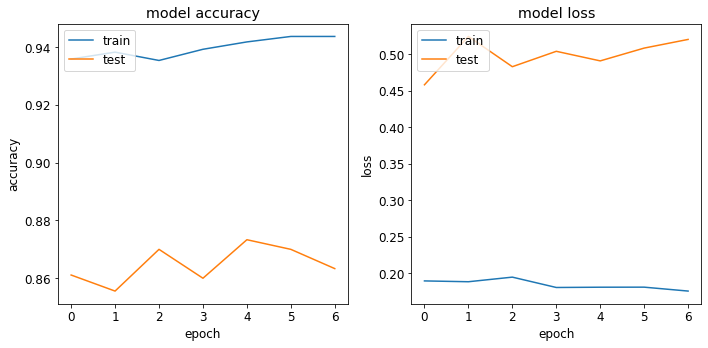

In [ ]:
# history_7 = model.fit(train_datagen_1,
#                       validation_data=valid_datagen_1,
#                       steps_per_epoch=380,
#                       epochs=7, # turn to 5 
#                       callbacks=[cb('G')])

# history_list.append(history_7.history)

# plot_loss(history_7)

In [ ]:
# Restore to 5th epoch weights
model = tf.keras.models.load_model('/content/G.weights.05-0.491.hdf5')

In [ ]:
# Switch: use validation set for training a few epochs so that the model can learn from new data
# Still keeping same optimizer as before
# Should have used the complete dataset for training, but out of time and internet bandwith to upload dataset again

history_8 = model.fit(valid_datagen_1,
                      steps_per_epoch=28,
                      epochs=8)


Epoch 1/8
28/28 [==============================] - 32s 1s/step - loss: 0.4844 - accuracy: 0.8709 - f1_score: 0.8735
Epoch 2/8
28/28 [==============================] - 29s 1s/step - loss: 0.4952 - accuracy: 0.8725 - f1_score: 0.8695
Epoch 3/8
28/28 [==============================] - 29s 1s/step - loss: 0.4537 - accuracy: 0.8772 - f1_score: 0.8761
Epoch 4/8
28/28 [==============================] - 29s 1s/step - loss: 0.4704 - accuracy: 0.8574 - f1_score: 0.8527
Epoch 5/8
28/28 [==============================] - 29s 1s/step - loss: 0.3887 - accuracy: 0.8803 - f1_score: 0.8809
Epoch 6/8
28/28 [==============================] - 29s 1s/step - loss: 0.3598 - accuracy: 0.8984 - f1_score: 0.8976
Epoch 7/8
28/28 [==============================] - 29s 1s/step - loss: 0.3201 - accuracy: 0.9093 - f1_score: 0.9071
Epoch 8/8
28/28 [==============================] - 29s 1s/step - loss: 0.3375 - accuracy: 0.8959 - f1_score: 0.8952


-------------

Prediction and Validation

In [ ]:
# Predicting directly from ImageDataGenerator even with shuffle off cause ordering probeleme
# Hence Creating np array to hold test data

test_images=[]
test_path = '/content/Custom - Oversampled/test/'

for i in sub.image_name:
    path = test_path+i
    img = tf.keras.preprocessing.image.load_img(path,
                                                grayscale=False,
                                                color_mode='rgb')#,
#                                                 target_size=(img_height, img_width),
                                                # interpolation='nearest')
    
    input_arr = preprocess_custom(img, img_height=img_height, img_width= img_width)
    test_images.append(input_arr)
    
test_set = np.array(test_images)

In [ ]:
label_list = [i for (i,j) in train_datagen_1.class_indices.items()]
label_map = {j:i for (i,j) in train_datagen_1.class_indices.items()}
label_map

{0: 'Adhered',
 1: 'Ballasted',
 2: 'Concrete',
 3: 'Plastic & fabric',
 4: 'Shingle',
 5: 'Steel'}

In [ ]:
predictions = model.predict(test_set)
sub['class'] = predictions.tolist()
sub['class'] = sub['class'].apply(np.argmax).map(label_map)

sub.to_csv('submission.csv', index=False)


from IPython.display import FileLink
FileLink(r'submission.csv')

/content/submission.csv

Validation

In [ ]:
valid_df = pd.read_csv('/content/Custom - Oversampled/valid_df.csv')
valid_df.head()

,image_name,class
0,5676.jpg,Adhered
1,2980.jpg,Adhered
2,147.jpg,Adhered
3,2258.jpg,Adhered
4,368.jpg,Adhered


In [ ]:
valid_images=[]
valid_path = '/content/Custom - Oversampled/validation/'

for i in valid_df.image_name:
    path = valid_path+i
    img = tf.keras.preprocessing.image.load_img(path,
                                                grayscale=False,
                                                color_mode='rgb',
                                                interpolation='nearest')

    input_arr = preprocess_custom(img, img_height=img_height, img_width= img_width)
    valid_images.append(input_arr)
    
valid_set = np.array(valid_images)

In [ ]:
validation_predictions_prob = model.predict(valid_set)
valid_df['predicted_class'] = validation_predictions_prob.tolist()
valid_df['predicted_class'] = valid_df['predicted_class'].apply(np.argmax).map(label_map)

In [ ]:
valid_df.head()

,image_name,class,predicted_class
0,5676.jpg,Adhered,Adhered
1,2980.jpg,Adhered,Adhered
2,147.jpg,Adhered,Adhered
3,2258.jpg,Adhered,Adhered
4,368.jpg,Adhered,Adhered


In [ ]:
print(classification_report(valid_df['class'], valid_df['predicted_class']))

                  precision    recall  f1-score   support

         Adhered       0.76      0.81      0.78       150
       Ballasted       0.89      0.92      0.90       150
        Concrete       0.94      0.88      0.91       150
Plastic & fabric       0.95      0.92      0.94       150
         Shingle       0.89      0.93      0.91       150
           Steel       0.85      0.81      0.83       150

        accuracy                           0.88       900
       macro avg       0.88      0.88      0.88       900
    weighted avg       0.88      0.88      0.88       900



In [ ]:
def plot_prediction_probablities(index_of_image, prob=validation_predictions_prob):
    
    sns.barplot(x=label_list, y=prob[index_of_image])
    plt.show()